# Машинное обучение ДЗ 3

Данное дз копия https://github.com/yandexdataschool/Practical_DL/blob/fall19/week05_nlp/part2_pytorch.ipynb

Однако содержит дополнительные задания на применение tf-idf и bag-of-words. 

# Natural Language Processing with Deep Learning

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
data = pd.read_csv("Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
224482,72420939,Aspnet MVC developer,Junior C Developer with strong ASP.NET MVC ski...,"Greater London, Central London",London,NaN,NaN,Real Staffing,Other/General Jobs,"50,000-74,999 yearly",62499,theladders.co.uk,11.042922
40221,68359799,Technical Product Manager – SQL / Web Services...,Technical Product Manager – SQL / Web Services...,London South East,South East London,NaN,permanent,Coal IT Services,IT Jobs,"From 38,000 to 42,000 per annum",40000,cwjobs.co.uk,10.596660
70313,68815219,"After School Nanny needed, French Speaking",Une famille recherche une super nounou francai...,Maida Vale,Maida Vale,NaN,NaN,NaN,Domestic help & Cleaning Jobs,10 per Hour,19200,findababysitter.com,9.862718


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [8]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [9]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [10]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [11]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
for text in np.hstack([data.FullDescription.values, data.Title.values]):
    tokens = tokenizer.tokenize(text)
    for token in tokens:
        token_counts[token] += 1

In [12]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('improvemen', 1)
('techniciancivil', 1)
('mlnlycke', 1)
Correct!


Text(0.5, 0, 'Counts')

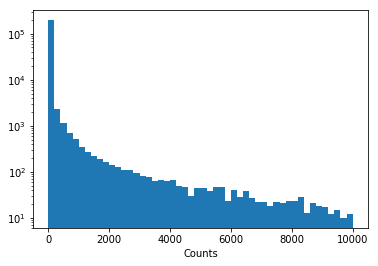

In [13]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

# Анализ данных и TF-IDF (3 балла)

В данном задании вам необходимо реализовать TF-IDF.

Использование готовых реализаций запрещено.

### Задание 1.1 (1 балл)
Возьмите топ 20% наиболее оплачиваемых вакансий и топ 20% наименее оплачиваемых вакансий.

В каждом классе посчитайте частоту слов.

Напечатайте топ 20 слов из каждого класса

In [16]:
top=data.sort_values(by='SalaryNormalized', ascending=False)[['SalaryNormalized','Title','FullDescription']].head(int(244768*0.2))
down=data.sort_values(by='SalaryNormalized', ascending=False)[['SalaryNormalized','Title','FullDescription']].tail(int(244768*0.2))
print(' ')

In [18]:
dik_top = Counter()
for text in np.hstack([top.FullDescription.values, top.Title.values]):
    tokens = tokenizer.tokenize(text)
    for token in tokens:
        dik_top[token] += 1

print('20 самых часто встречающихся слов для самых высокооплачиваемых профессий')
print("Total unique tokens :", len(dik_top))
print('\n'.join(map(str, dik_top.most_common(n=20))))


20 самых часто встречающихся слов для самых высокооплачиваемых профессий
Total unique tokens : 73447
('and', 570951)
('.', 510158)
(',', 507319)
('the', 458269)
('to', 383120)
('of', 322691)
('a', 304461)
('in', 215703)
('for', 175143)
('with', 155096)
('will', 133763)
('/', 132964)
('****', 125221)
('is', 120340)
('you', 119845)
('be', 116580)
('experience', 105019)
('this', 101198)
('as', 92916)
('an', 88781)


In [19]:
dik_down = Counter()
for text in np.hstack([down.FullDescription.values, down.Title.values]):
    tokens = tokenizer.tokenize(text)
    for token in tokens:
        dik_down[token] += 1

print('20 самых часто встречающихся слов для самых низкооплачиваемых профессий')
print("Total unique tokens :", len(dik_down))
print('\n'.join(map(str, dik_down.most_common(n=20))))

20 самых часто встречающихся слов для самых низкооплачиваемых профессий
Total unique tokens : 69775
('.', 460496)
('and', 441559)
('to', 389106)
(',', 353799)
('the', 344164)
('a', 269570)
('of', 221087)
('in', 178361)
('for', 154262)
('you', 141332)
('with', 125176)
('****', 125143)
('be', 124829)
('will', 117073)
('is', 110284)
('are', 89092)
('as', 88269)
('this', 85230)
(':', 77246)
('/', 76969)


### Задание 1.2 (2 балла)

Возьмите топ 20% наиболее оплачиваемых вакансий и топ 20% наименее оплачиваемых вакансий. 

В каждом классе посчитайте суммарный tf-idf для каждого слова

Напечатайте топ 20 слов из каждого класса

Взято отсюда и немного переделанно http://nlpx.net/archives/57

In [20]:
import math

def compute_tfidf(corpus):

  def compute_tf(text):

    tf_text = Counter(text)

    for i in tf_text:

      tf_text[i] = tf_text[i]/float(len(text))

    return tf_text

  def compute_idf(word, corpus):

    return math.log10(len(corpus)/sum([1.0 for i in corpus if word in i]))

  for text in corpus:

    computed_tf = compute_tf(text)

    for word in computed_tf:

      computed_tf[word] = computed_tf[word] * compute_idf(word, corpus)

  return computed_tf

words_down=compute_tfidf([down.FullDescription.values, down.Title.values])
print(words_down.most_common(n=20))

[('cleaner', 0.003505139573232882), ('administrator', 0.002465896436607694), ('support worker', 0.0018202128310121635), ('accounts assistant', 0.0017956153603228098), ('credit controller', 0.001752569786616441), ('assistant manager', 0.0015619393887739512), ('chef de partie', 0.0015619393887739512), ('cleaning operative', 0.0013774583586037995), ('purchase ledger clerk', 0.0013528608879144457), ('customer service advisor', 0.001279068475846385), ('labourer', 0.0012421722698123547), ('receptionist', 0.0012360229021400164), ('sales executive', 0.0011560811223996173), ('teaching assistant', 0.0010023469305911576), ('care assistant', 0.0009654507245571273), ('sales administrator', 0.000947002621540112), ('telesales executive', 0.0009285545185230968), ('nursery nurse', 0.00091625578317842), ('warehouse operative', 0.0008240152680933442), ('legal secretary', 0.0007010279146465765)]


In [21]:
words_top=compute_tfidf([top.FullDescription.values, top.Title.values])
print(words_top.most_common(n=20))

[('project manager', 0.0017771672573057948), ('business development manager', 0.0015373419180845975), ('financial controller', 0.0015373419180845975), ('finance manager', 0.0011130355486932485), ('business analyst', 0.0007379241206806067), ('senior quantity surveyor', 0.0006579823409402077), ('senior project manager', 0.000645683605595531), ('hr business partner', 0.0006395342379231925), ('commercial finance manager', 0.0005534430905104551), ('hr manager', 0.0005472937228381166), ('engineering manager', 0.0005411443551657783), ('mechanical design engineer', 0.0004796506784423944), ('sales manager', 0.0004796506784423944), ('marketing manager', 0.000473501310770056), ('java developer', 0.0004673519430977176), ('commercial manager', 0.00046120257542537924), ('financial accountant', 0.00046120257542537924), ('senior estimator', 0.00045505320775304087), ('management accountant', 0.00044890384008070244), ('finance director', 0.0004304557370636873)]


# Bag of words (3 балла)

В данном задании вам необходимо построить регрессию поверх bag-of-words

Можно использовать любые библиотеки

In [0]:
#берем векторайзер
from sklearn.feature_extraction.text import CountVectorizer
vektor = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 




In [0]:
#Соединяем тайтл и дискрипшн для каждого наблюдения
e=[]
for i in range(data.FullDescription.shape[0]):
  ee = str(data.FullDescription.values[i]) + str(data.Title.values[i])
  e.append(ee) #Превращаем в лист,чтобы подать векторайзеру на вход
new=vektor.fit_transform(e)  #Получаем все в векторизированном виде



In [24]:
vocab = vektor.get_feature_names()
print (vocab)

['00', '000', '00am', '00pm', '013', '10', '100', '10am', '10pm', '11', '12', '13', '14', '15', '16', '17', '17th', '18', '1990', '1st', '20', '200', '2000', '2003', '2005', '2008', '201', '2010', '2011', '2012', '2013', '2014', '21', '22', '23', '24', '25', '25th', '26', '27', '28', '29', '2nd', '2pm', '30', '30am', '30pm', '31', '33', '34', '35', '36', '37', '3d', '3rd', '40', '45', '4pm', '4th', '50', '5pm', '60', '6am', '6pm', '70', '7am', '80', '8am', '8pm', '9001', '9am', '_job', 'aa', 'aat', 'aberdeen', 'aberdeenshire', 'abilities', 'ability', 'able', 'about', 'above', 'abreast', 'abroad', 'absence', 'absolute', 'absolutely', 'ac', 'aca', 'academic', 'academics', 'academy', 'acca', 'accept', 'acceptable', 'acceptance', 'accepted', 'access', 'accessible', 'accessories', 'accident', 'accommodate', 'accommodation', 'accomplished', 'accordance', 'according', 'accordingly', 'account', 'accountabilities', 'accountability', 'accountable', 'accountancy', 'accountant', 'accountants', 'ac

In [25]:
from sklearn.linear_model import LinearRegression
model= LinearRegression(normalize= True)
model.fit(new, data['SalaryNormalized'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [26]:
model.score(new, data['SalaryNormalized'])


0.5633346114165246

# Нейросетевой подход (4 балла)

Вам необходимо сделать весь оставшийся ноутбук.


enjoy :)

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [14]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count >= min_count] 

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [15]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [16]:
token_to_id = {token: index for index, token in enumerate(tokens)}

In [17]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [18]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [19]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[    2     3     4     1     1]
 [  548  2361     1     1     1]
 [  537 10662   390   307    32]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [20]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [21]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [22]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [23]:
generate_batch(data_train, 3, max_len=10)

{'Title': array([[10309,  1016,  3060,     1],
        [  555,  2361,  1367,  6670],
        [  985,  3623,     1,     1]]),
 'FullDescription': array([[   10,   242,    71,    44,   422,   653, 10309,  1016,   655,
            34],
        [  819,    49,   171,    65,   103,  1949,  3798,    15,  2997,
            15],
        [ 1571,  2619,   266,   121,   413,  3065,   413,  2661,   129,
           985]]),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([9.852247, 9.403849, 9.386309], dtype=float32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [24]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

ModuleNotFoundError: No module named 'torch'

In [ ]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        layer1 = nn.Sequential(self.conv1 , self.pool1, nn.ReLU() ,self.dense) 
        out = layer1(h)
        
        return out

In [ ]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

__Task 2.1__ Create description encoder

In [ ]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DeskEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        layer1 = nn.Sequential(self.conv1 , self.pool1, nn.ReLU() ,self.dense) 
        out = layer1(h)
        
        return out

In [ ]:
desc_encoder = DeskEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

__ Task 2.2__ Build one network ~~to rule them all~~

In [ ]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DeskEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.layer1 = nn.Sequential(nn.Linear(n_cat_features,64), nn.Linear(64,64)) 
        # define "output" layers that process depend the three encoded vectors into answer
        self.outlayer=nn.Sequential( nn.Linear(128+64,32) )
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.layer1(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        final = self.outlayer(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return final[:, 0]

In [ ]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [ ]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [ ]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [ ]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [ ]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [ ]:
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.numpy()
            val_mae += compute_mae(reference, prediction).data.numpy()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

In [ ]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

### Бонусная секция. Любые разумные попытки улучшить архитектуру поощряются дополнительными баллами. Чтобы мы не пропустили ваши старания - опишите ниже, что вы сделали (это должно быть видно и в коде). (max 4 балла).


### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...